## KNN Model training on Big Mart Sales Data

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

### Read CSV Training Data

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Fill in missing data

In [3]:
print(df.isnull().sum())

# missing values in Item_weight and Outlet_size needs to be imputed
mean = df['Item_Weight'].mean() #imputing item weight with the mean
df['Item_Weight'].fillna(mean, inplace=True)

mode = df['Outlet_Size'].mode() #imputing outlet size with mode
df['Outlet_Size'].fillna(mode[0], inplace=True)

In [4]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Drop ID columns and deal with categorical variables (using `pd.get_dummies()`)

In [5]:
df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1, inplace=True)
df = pd.get_dummies(df)

In [6]:
df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,249.8092,1999,3735.1380,False,True,False,False,False,...,False,True,False,True,False,False,False,True,False,False
1,5.92,0.019278,48.2692,2009,443.4228,False,False,True,False,False,...,False,True,False,False,False,True,False,False,True,False
2,17.50,0.016760,141.6180,1999,2097.2700,False,True,False,False,False,...,False,True,False,True,False,False,False,True,False,False
3,19.20,0.000000,182.0950,1998,732.3800,False,False,True,False,False,...,False,True,False,False,False,True,True,False,False,False
4,8.93,0.000000,53.8614,1987,994.7052,False,True,False,False,False,...,True,False,False,False,False,True,False,True,False,False


### Create and preprocess train and test datasets

1. Split training dataset

In [9]:
train, test = train_test_split(df, test_size=0.3) # 70% train and 30% test

x_train = train.drop('Item_Outlet_Sales', axis=1) # we are attempting to predict item outlet sales
y_train = train['Item_Outlet_Sales']

x_test = test.drop('Item_Outlet_Sales', axis=1)
y_test = test['Item_Outlet_Sales']

2. Scale features

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

### Get **error rate** for different k values

In [13]:
rmse_val = []

for K in range(30): 
    K = K+1 # check k values from 1 to 20
    model = neighbors.KNeighborsRegressor(n_neighbors=K)

    model.fit(x_train, y_train) # fit the model
    pred = model.predict(x_test) # make predictions on the test set
    error = sqrt(mean_squared_error(y_test, pred)) # calculate rmse
    rmse_val.append(error) # store rmse value for each loop
    print('RMSE value for k = ', K, 'is: ', error)

RMSE value for k =  1 is:  1590.6224489012166
RMSE value for k =  2 is:  1345.5671293653268
RMSE value for k =  3 is:  1292.7636389622041
RMSE value for k =  4 is:  1269.2234789463485
RMSE value for k =  5 is:  1252.2811080641593
RMSE value for k =  6 is:  1244.2641349827868
RMSE value for k =  7 is:  1236.2305889118356
RMSE value for k =  8 is:  1232.2864606678042
RMSE value for k =  9 is:  1230.3174390508614
RMSE value for k =  10 is:  1226.2348100833974
RMSE value for k =  11 is:  1227.7488899379891
RMSE value for k =  12 is:  1233.6225319125645
RMSE value for k =  13 is:  1233.1621302309102
RMSE value for k =  14 is:  1240.0369567355258
RMSE value for k =  15 is:  1241.9622167532227
RMSE value for k =  16 is:  1244.1195437291356
RMSE value for k =  17 is:  1251.0276878225086
RMSE value for k =  18 is:  1257.1186801475424
RMSE value for k =  19 is:  1265.579378092937
RMSE value for k =  20 is:  1269.2532123085552
RMSE value for k =  21 is:  1274.3477079210124
RMSE value for k =  22 

<Axes: >

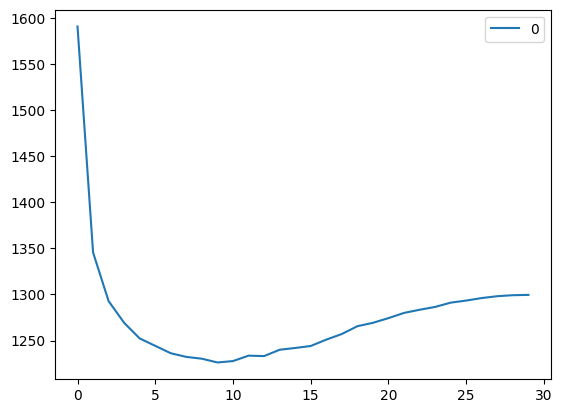

In [14]:
# plot the rmse values against k values
curve = pd.DataFrame(rmse_val) # this is the elbow curve
curve.plot()

### Make predictions on the test dataset

In [16]:
# reading test and sample submission files
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
submission['Item_Identifier'] = test['Item_Identifier']
submission['Outlet_Identifier'] = test['Outlet_Identifier']

# preprocessing the test dataset
test.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1, inplace=True)
test['Item_Weight'].fillna(mean, inplace = True)
test = pd.get_dummies(test)
test_scaled = scaler.fit_transform(test)
test = pd.DataFrame(test_scaled)

# predicting on the test set and creating the submission file
predict = model.predict(test)
submission['Item_Outlet_Sales'] = predict
submission.to_csv('submit_file.csv', index=False)

Your score for this submission is : 1333.3325604087993.

### Do a grid search for the optimal k value

In [18]:
params = {'n_neighbors':[5,6,7,8,9,10,11,12,13,14,15]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(x_train, y_train)
model.best_params_

{'n_neighbors': 7}

### Get the best-fit KNN model using K = 7

In [19]:
K = 7 # set k value to 7
model = neighbors.KNeighborsRegressor(n_neighbors=K)

model.fit(x_train, y_train) # fit the model
pred = model.predict(x_test) # make predictions on the test set
error = sqrt(mean_squared_error(y_test, pred)) # calculate rmse
rmse_val.append(error) # store rmse value for each loop
print('RMSE value for k = ', K, 'is: ', error)

RMSE value for k =  7 is:  1236.2305889118356


In [20]:
# reading test and sample submission files
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
submission['Item_Identifier'] = test['Item_Identifier']
submission['Outlet_Identifier'] = test['Outlet_Identifier']

# preprocessing the test dataset
test.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1, inplace=True)
test['Item_Weight'].fillna(mean, inplace = True)
test = pd.get_dummies(test)
test_scaled = scaler.fit_transform(test)
test = pd.DataFrame(test_scaled)

# predicting on the test set and creating the submission file
predict = model.predict(test)
submission['Item_Outlet_Sales'] = predict
submission.to_csv('submit_file.csv', index=False)

Your score for this submission is : 1273.9549817274365.